Decisões para o projeto:
* criar copia do dataframe a cada nova seção
* explicar gráficos
* 

Subseções:
    
* 

# RESUMO

## Sobre o projeto

Previsão de vendas das próximas 6 semanas (42 dias).

O formato de entrega será o valor total das vendas no final dessas 6 semanas (2 colunas: código da loja e valor total das vendas previsto) e com checagem pelo smartphone (verificação da loja desejada, seu valor de vendas e o comportamento das vendas durante essas 6 semanas).

## Dicionário dos dados

Data fields
Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* **Id** - an Id that represents a (Store, Date) duple within the test set
* **Store** - a unique Id for each store
* **Sales** - the turnover for any given day (this is what you are predicting)
* **Customers** - the number of customers on a given day
* **Open** - an indicator for whether the store was open: 0 = closed, 1 = open
* **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools
* **StoreType** - differentiates between 4 different store models: a, b, c, d
* **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
* **CompetitionDistance** - distance in meters to the nearest competitor store
* **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
* **Promo** - indicates whether a store is running a promo on that day
* **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
* **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# IMPORTS

In [1]:
# importações de pacotes
import pandas as pd
import numpy as np
from math import isnan
import inflection
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Carregamento dos dados

In [2]:
# leitura dos dados
# informações de vendas (train)
# informações das lojas (store)
df_sales_raw = pd.read_csv('data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('data/store.csv', low_memory = False)

In [3]:
df_sales_raw.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
# head
df_store_raw.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:
# unir os 2 datasets (esquerda, coluna "store" de chave)
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')

In [6]:
df_raw.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## Funções auxiliares

# DESCRIÇÃO DOS DADOS

## Renomeando as colunas

In [7]:
# criar cópia do df
df1 = df_raw.copy()

In [8]:
# verificar colunas e seus nomes
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [9]:
# criar lista com os nomes das colunas
cols_atuais = df1.columns

In [10]:
# criar função lambda "snakecase" para passar tudo para minuscula
snakecase = lambda x: inflection.underscore(x)

In [11]:
# utilizar map
cols_novas = list(map(snakecase, cols_atuais))

In [12]:
#renomear
df1.columns = cols_novas

## Dimensão dos dados

In [13]:
# número de linhas e colunas
print(f'Número de linhas: {df1.shape[0]}')
print(f'Número de colunas: {df1.shape[1]}')

Número de linhas: 1017209
Número de colunas: 18


## Tipos de dados e conversão de "date"

In [14]:
# tipos de dados
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [15]:
# converter "date" para o tipo "date"
df1['date'] = pd.to_datetime(df1['date'])

In [16]:
# tipos de dados
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## Checagem de valores NA

In [17]:
# somas das colunas que possuam pelo menos 1 valor NA
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## Preenchendo dados nulos

In [18]:
#competition_distance              2642
#competition_open_since_month    323348
#competition_open_since_year     323348                               
#promo2_since_week               508031
#promo2_since_year               508031
#promo_interval                  508031

**competition_distance**: se há valor NA, provavelmente não há competidor mais próximo (não há competição).

Uma solução seria preencher os campos nulos com valores muito mais altos do que o valor máximo da coluna, pois assim sinalizamos que não há competição.

In [19]:
# verificar valor máximo da coluna
df1.competition_distance.max()

75860.0

In [20]:
# verificar com isnan se a linha da coluna definida "é nula"
# caso a linha seja "nula", vamos preenche-la com o valor 2000000. Senão, retorna o valor da linha
# usar lambda e apply e apenas na coluna
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if isnan(x) else x)

**competition_open_since_month**: talvez existam 2 razões para essa coluna estar vazia: não há competidor mais próximo, então não há data de abertura para ele, ou há competidor mais próximo e não se sabe quando abriu.

Podemos preencher os valores NA extraindo o mês da própria linha (cada linha representa uma venda em uma data, em uma loja). Isso pode ser feito já pensando na etapa de feature engineering, pois há colunas que são importantes para mostrarem um comportamento ao longo do tempo (nesse caso, sobre a competição ao longo do tempo). 

A substituição acima será feita com o valor do mês da coluna "date"se o valor da coluna for nulo. Senão, será retornado o valor que já existe.

Caso essa solução não funcione, podemos voltar e alterá-la (graças ao CRISP-DS).

In [21]:
# aplicar apenas nas colunas
# como serão utilizadas mais de uma coluna, precisamos especificar que será por colunas e utilizar o df com
# a função apply
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)                                         

**competition_open_since_year**: mesmo raciocínio acima

In [22]:
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)       

**promo2_since_week** e **promo2_since_year**-> promo 2 é a continuação de uma promoção pra algumas lojas. Se for 0 ela não está participando e se for 1, está.

Se o valor for NA, quer dizer que a loja decidiu não participar dessa promoção.

Substituiremos o valor nulo pelo valor da semana daquela linha.

In [23]:
# mesmo raciocínio da coluna anterior
# extrair week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

In [24]:
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

**promo_interval** -> meses em que a promoção 2 ficou ativa.

Vamos criar uma coluna chamada "month_map" com o mês da venda (da linha)

Se promo_interval for NA, vamos preencher com 0 (preencher diretamente na coluna). 

Faremos um split do valor da coluna e insetir em uma lista. Se o mês de month_map estiver dentro dessa lista, vamos criar uma coluna dizendo que a promoção 2 estava ativa.

In [25]:
# criar dicionário com os meses
month_map = {1: 'Jan',
2: 'Feb',
3: 'Mar',
4: 'Apr',
5: 'May',
6: 'Jun',
7: 'Jul',
8: 'Aug',
9: 'Sep',
10: 'Oct',
11: 'Nov',
12: 'Dec'}

In [26]:
# preencher com 0 se for NA (fillna)
df1['promo_interval'].fillna(0, inplace = True)

In [27]:
# criar coluna month_map(dicionário). Fazer com que ela receba o valor do mês da coluna date, mas esse mês
# deve ser com o nome inserido no dicionário
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1.month_map

0          Jul
1          Jul
2          Jul
3          Jul
4          Jul
          ... 
1017204    Jan
1017205    Jan
1017206    Jan
1017207    Jan
1017208    Jan
Name: month_map, Length: 1017209, dtype: object

In [28]:
# verificar se o valor de month_map está dentro da lista criada:
# criar coluna is_promo
# recebe 1 se estiver; recebe 0 se não estiver
# se promo_interval for == 0, retornamos 0 (a loja não está participando)
# utilizar apenas as colunas promo_interval e month_map
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)                                

In [29]:
df1.head(10)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,31.0,2015.0,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,31.0,2015.0,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,31.0,2015.0,0,Jul,0
5,6,5,2015-07-31,5651,589,1,1,0,1,a,a,310.0,12.0,2013.0,0,31.0,2015.0,0,Jul,0
6,7,5,2015-07-31,15344,1414,1,1,0,1,a,c,24000.0,4.0,2013.0,0,31.0,2015.0,0,Jul,0
7,8,5,2015-07-31,8492,833,1,1,0,1,a,a,7520.0,10.0,2014.0,0,31.0,2015.0,0,Jul,0
8,9,5,2015-07-31,8565,687,1,1,0,1,a,c,2030.0,8.0,2000.0,0,31.0,2015.0,0,Jul,0
9,10,5,2015-07-31,7185,681,1,1,0,1,a,a,3160.0,9.0,2009.0,0,31.0,2015.0,0,Jul,0


## Alteração de tipos

Pode ser que alguma das alterações que foram feitas anteriormente tenha mudado o tipo de algum dos dados. Vamos verificar e alterar, caso necessário.

In [30]:
# tipos
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [31]:
# competition_open_since_month para int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int')

In [32]:
# competition_open_since_year para int
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int')

In [33]:
# promo week
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int')

In [34]:
# promo year
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int')

## Estatística descritiva

Essa etapa da análise dos dados pode nos ajudar a ganhar conhecimento do negócio.

Também nessa etapa podemos verificar as métricas de estatística de primeira ordem: medidas de tendência central e medidas de dispersão.

* Medidas de tendência central ➔ média e mediana

* Medidas de dispersão ➔ desvio padrão, mínimo, máximo, range, skew e kurtose

Antes de verificarmos as estatísticas descritivas, precisamos separar as variáveis numéricas e categóricas no dataset.

In [35]:
# separando as variáveis
# num_attributes(include) e cat_attributes (exclude)
atributos_numericos = df1.select_dtypes(include = 'number')
atributos_categoricos = df1.select_dtypes(exclude = ['number', 'datetime'])

### Estatísticas das variáveis numéricas

In [36]:
# aplicar a média a todas as colunas e transformar em um df transposto
# fazer a mesma coisa para mediana
medias = pd.DataFrame(atributos_numericos.apply(np.mean)).T
medianas = pd.DataFrame(atributos_numericos.apply(np.median)).T

In [37]:
# aplicar as medidas de dispersão a todas as colunas e transformar cada uma em um df transposto
# calcular o range manualmente?
# lambda
std = pd.DataFrame(atributos_numericos.apply(np.std)).T
minimo = pd.DataFrame(atributos_numericos.apply(min)).T
maximo = pd.DataFrame(atributos_numericos.apply(max)).T
val_range = pd.DataFrame(atributos_numericos.apply(lambda x: x.max() - x.min())).T
skew = pd.DataFrame(atributos_numericos.apply(lambda x: x.skew())).T
kurtose = pd.DataFrame(atributos_numericos.apply(lambda x: x.kurtosis())).T

In [38]:
# concatenar
medidas_estatisticas = pd.concat([medias, medianas, std, minimo, maximo, val_range, skew, kurtose]).T.reset_index()

In [39]:
# nomear as colunas
medidas_estatisticas.columns = ['variaveis', 'media', 'mediana', 'desvio padrao', 'min', 'max', 'range', 'skew', 
                        'curtose']

In [40]:
medidas_estatisticas

,variaveis,media,mediana,desvio padrao,min,max,range,skew,curtose
0,store,558.429727,558.0,321.908493,1.0,1115.0,1114.0,-0.000955,-1.200524
1,day_of_week,3.998341,4.0,1.997390,1.0,7.0,6.0,0.001593,-1.246873
2,sales,5773.818972,5744.0,3849.924283,0.0,41551.0,41551.0,0.641460,1.778375
3,customers,633.145946,609.0,464.411506,0.0,7388.0,7388.0,1.598650,7.091773
4,open,0.830107,1.0,0.375539,0.0,1.0,1.0,-1.758045,1.090723
5,promo,0.381515,0.0,0.485758,0.0,1.0,1.0,0.487838,-1.762018
6,school_holiday,0.178647,0.0,0.383056,0.0,1.0,1.0,1.677842,0.815154
7,competition_distance,5935.442677,2330.0,12547.646829,20.0,200000.0,199980.0,10.242344,147.789712
8,competition_open_since_month,6.786849,7.0,3.311085,1.0,12.0,11.0,-0.042076,-1.232607
9,competition_open_since_year,2010.324840,2012.0,5.515591,1900.0,2015.0,115.0,-7.235657,124.071304


<AxesSubplot:xlabel='sales', ylabel='Density'>

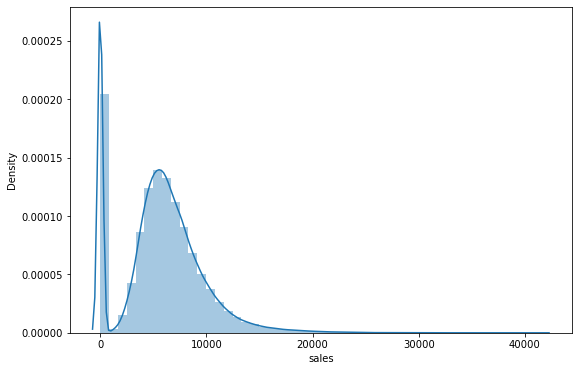

In [41]:
# plotar distribuição das vendas
plt.figure(figsize = (9,6))
sns.distplot(atributos_numericos['sales'])

Acima percebemos uma skew positiva (deslocada um pouco para a esquerda) e uma distribuição próxima de uma normal.

<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

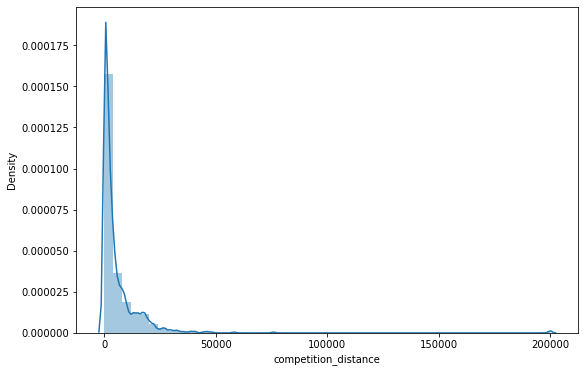

In [42]:
# plotar distribuição de competition_distance
plt.figure(figsize = (9,6))
sns.distplot(atributos_numericos['competition_distance'])

Parece ser uma distribuição poisson. Isso indica que os competidores estão próximos, com distância próxima de 0. Isso é indicado pela skew muito positiva. 

Como os valores estão muito concentrados, temos uma kurtose muito alta.

### Estatísticas das variáveis categóricas

In [43]:
# verificar quantos níveis cada coluna categórica possui
atributos_categoricos.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

In [44]:
# ver valores de state_holiday
atributos_categoricos['state_holiday'].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

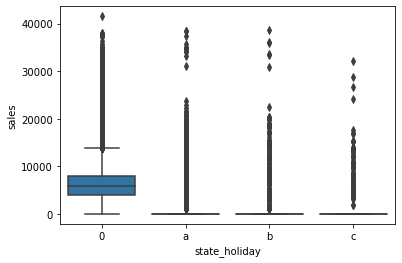

In [45]:
# boxplot vendas de acordo com o feriado estadual (df1)
sns.boxplot(data = df1,  x = 'state_holiday', y = 'sales');

O gráfico acima não nos mostra muita coisa, pois há dias com as lojas fechadas, dias com poucas vendas e dias com vendas altas. Isso gera um range muito alto. 

Podemos então filtrar esses números:

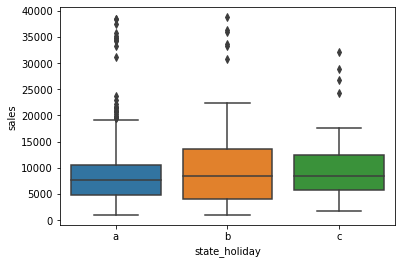

In [46]:
# State_holiday != 0(0 representa loja fechada?) e sales > 0
vendas_state_holiday = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
sns.boxplot(data = vendas_state_holiday,  x = 'state_holiday', y = 'sales');

<AxesSubplot:xlabel='assortment', ylabel='sales'>

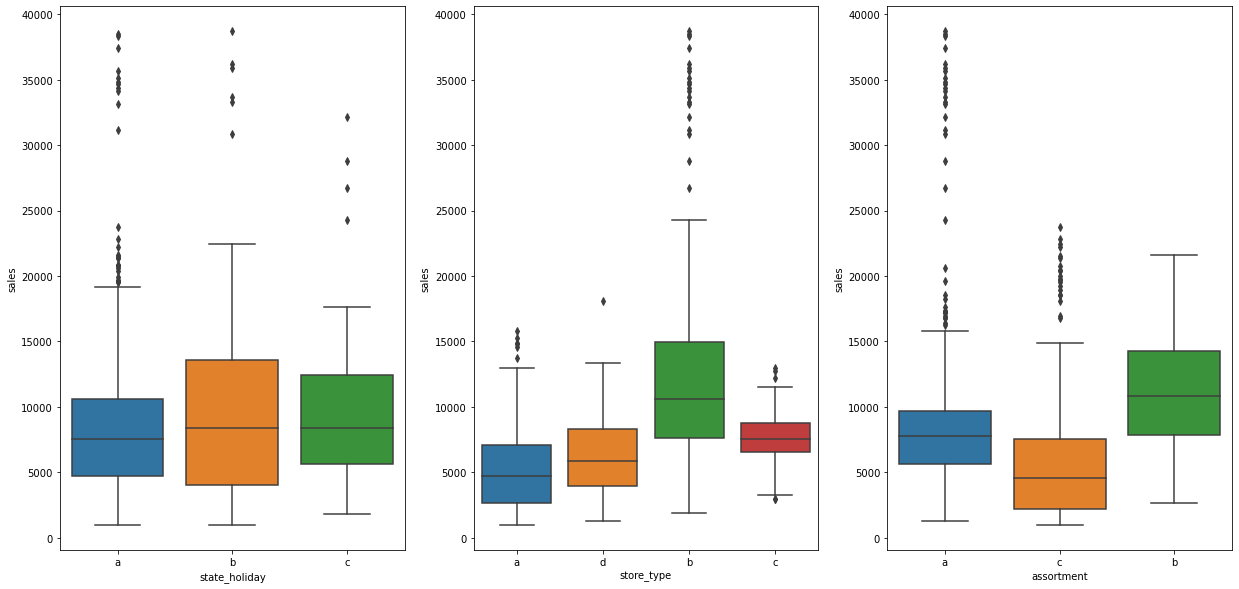

In [59]:
# fazer subplots com store's e assortment
# state_holiday, store_type, assortment 
plt.figure(figsize = (21,10))

plt.subplot(1,3,1)
sns.boxplot(data = vendas_state_holiday,  x = 'state_holiday', y = 'sales')

plt.subplot(1,3,2)
sns.boxplot(data = vendas_state_holiday,  x = 'store_type', y = 'sales')

plt.subplot(1,3,3)
sns.boxplot(data = vendas_state_holiday,  x = 'assortment', y = 'sales')

# FEATURE ENGINEERING